# OCR Project 03: Licence plate reading


# Installing the libraries

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
mkdir: cannot create directory ‘tessdata’: File exists
--2022-04-07 17:18:59--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2022-04-07 17:18:59--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2022-04-07 17:18:59--  https://raw.githubusercontent.com/tesse

# Connection to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -R /content/gdrive/MyDrive/Cursos\ -\ recursos/OCR\ with\ Python/Images/Images\ Project\ 3 images/

# Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import imutils
import pytesseract
from matplotlib import pyplot as plt

In [ ]:
def show_img(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 8)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Pre-processing the image

In [ ]:
img = cv2.imread('/content/images/car1.jpg')
(H, W) = img.shape[:2]
print(H, W)

741 920


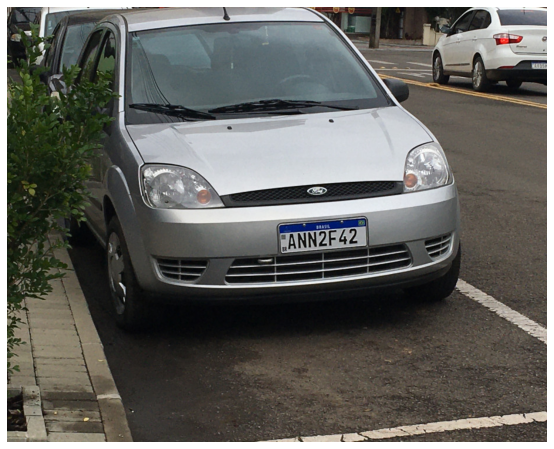

In [ ]:
show_img(img)

## Grayscale

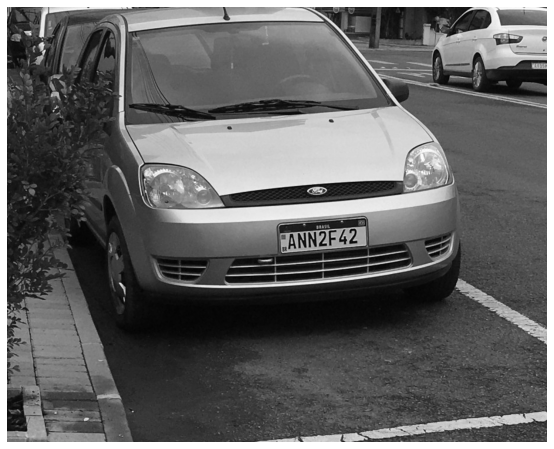

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(gray)

## Blur

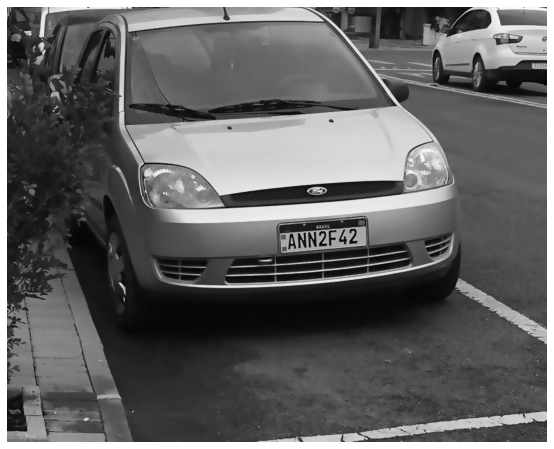

In [ ]:
blur = cv2.bilateralFilter(gray, 11, 17, 17)
show_img(blur)

## Edges (Canny Edge)

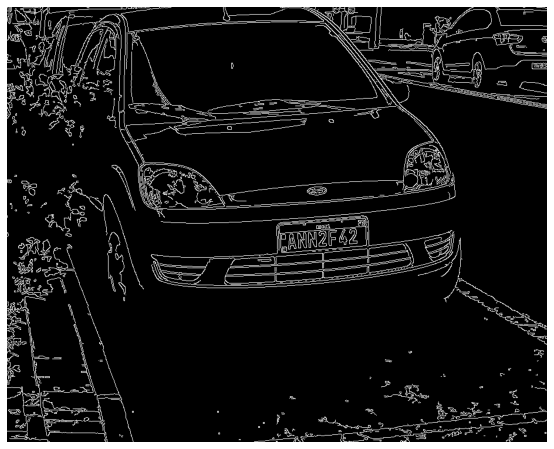

In [ ]:
edged = cv2.Canny(blur, 30, 200)
show_img(edged)

## Contours

In [ ]:
conts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8]

In [ ]:
conts

## Finding the region

In [ ]:
location = None
for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)
    if cv2.isContourConvex(aprox):
      if len(aprox) == 4:
          location = aprox
          break

In [ ]:
location

array([[[611, 375]],

       [[610, 406]],

       [[467, 417]],

       [[466, 385]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)

In [ ]:
mask.shape

(741, 920)

In [ ]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

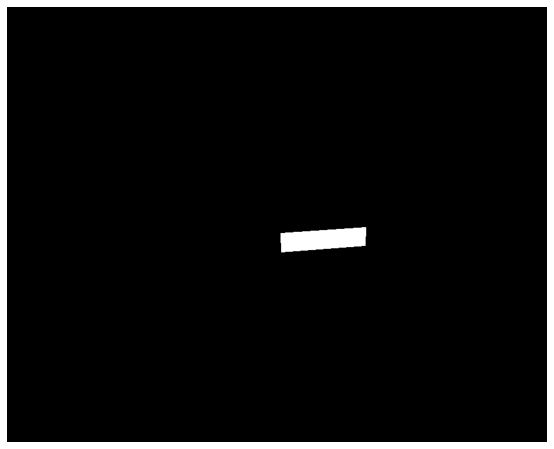

In [ ]:
img_plate = cv2.drawContours(mask, [location], 0, 255, -1)
show_img(mask)

In [ ]:
img_plate = cv2.bitwise_and(img, img, mask=mask)

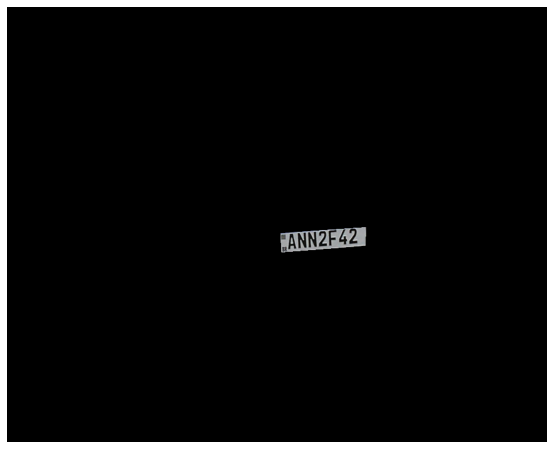

In [ ]:
show_img(img_plate)

In [ ]:
(y, x) = np.where(mask==255)
(beginX, beginY) = (np.min(x), np.min(y))
(endX, endY) = (np.max(x), np.max(y))

In [ ]:
beginX, beginY, endX, endY

(466, 375, 611, 417)

In [ ]:
plate = gray[beginY:endY, beginX:endX]

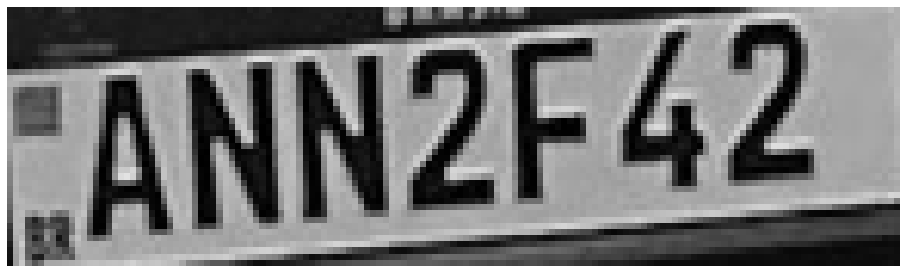

In [ ]:
show_img(plate)

# Text recognition

In [ ]:
config_tesseract = "--tessdata-dir tessdata --psm 6"

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [ ]:
text = pytesseract.image_to_string(plate, lang="por", config=config_tesseract)
print(text)

"ANN2F42



In [ ]:
text

'"ANN2F42\n\x0c'

In [ ]:
text = "".join(character for character in text if character.isalnum())
text

'ANN2F42'

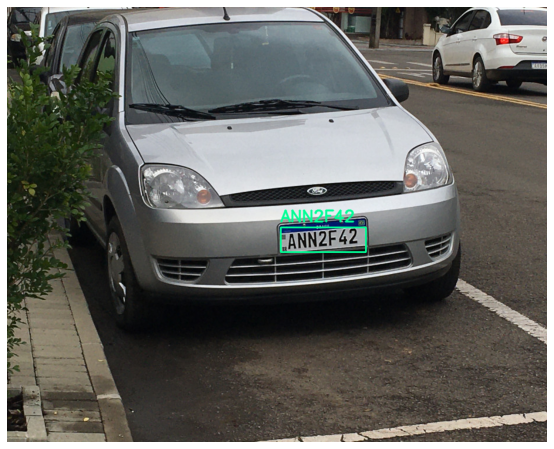

In [ ]:
img_final = cv2.putText(img, text, (beginX, beginY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (150,255,0), 2, lineType=cv2.LINE_AA)
img_final = cv2.rectangle(img, (beginX, beginY), (endX, endY), (150, 255, 0), 2)
show_img(img_final)

In [ ]:
def detect_plate(file_img):
  img = cv2.imread(file_img)
  (H, W) = img.shape[:2]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.bilateralFilter(gray, 11, 17, 17)
  edged = cv2.Canny(blur, 30, 200)
  show_img(edged)
  conts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8]

  location = None
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)
    if cv2.isContourConvex(aprox):
      if len(aprox) == 4:
          location = aprox
          break

  beginX = beginY = endX = endY = None
  if location is None:
    plate = False
  else:
    mask = np.zeros(gray.shape, np.uint8)

    img_plate = cv2.drawContours(mask, [location], 0, 255, -1)
    img_plate = cv2.bitwise_and(img, img, mask=mask)

    (y, x) = np.where(mask==255)
    (beginX, beginY) = (np.min(x), np.min(y))
    (endX, endY) = (np.max(x), np.max(y))

    plate = gray[beginY:endY, beginX:endX]
    show_img(plate)

  return img, plate, beginX, beginY, endX, endY

In [ ]:
def ocr_plate(plate):
  config_tesseract = "--tessdata-dir tessdata --psm 6"
  text = pytesseract.image_to_string(plate, lang="por", config=config_tesseract)
  text = "".join(c for c in text if c.isalnum())
  return text

In [ ]:
def recognize_plate(file_img):
  img, plate, beginX, beginY, endX, endY = detect_plate(file_img)

  if plate is False:
    print("It was not possible to detect!")
    return 0

  text = ocr_plate(plate)
  print(text)
  img = cv2.putText(img, text, (beginX, beginY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (150,255,0), 2, lineType=cv2.LINE_AA)
  img = cv2.rectangle(img, (beginX, beginY), (endX, endY), (150, 255, 0), 2)
  show_img(img)

  return img, plate

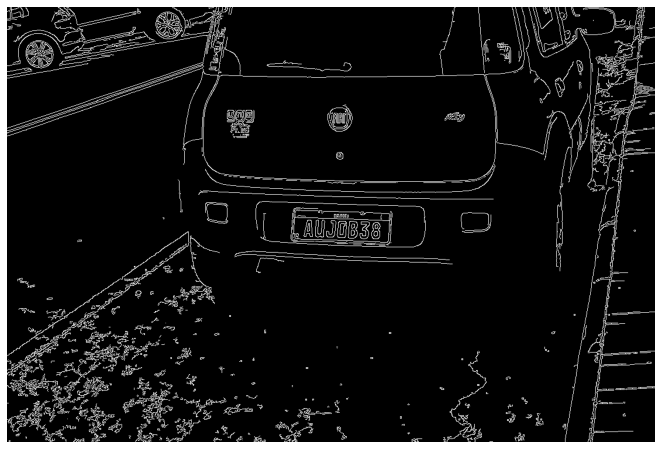

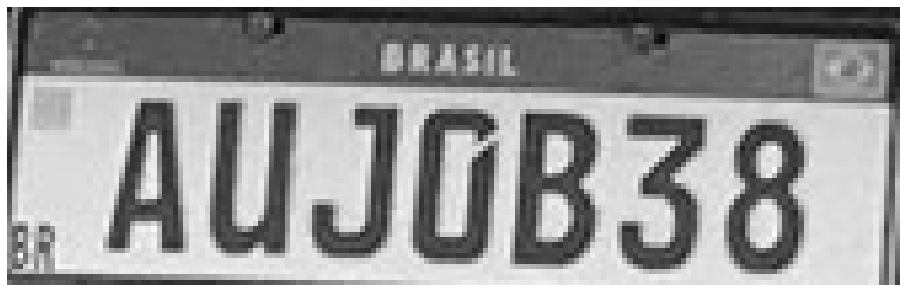

AUJOB38


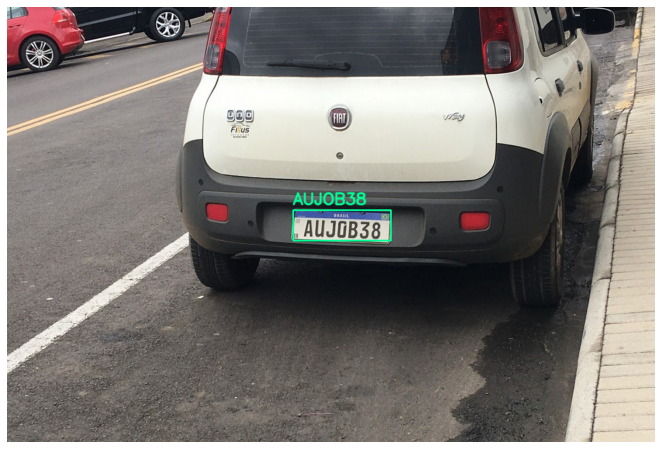

In [ ]:
img, plate = recognize_plate('/content/images/car2.jpg')

# Improving the quality

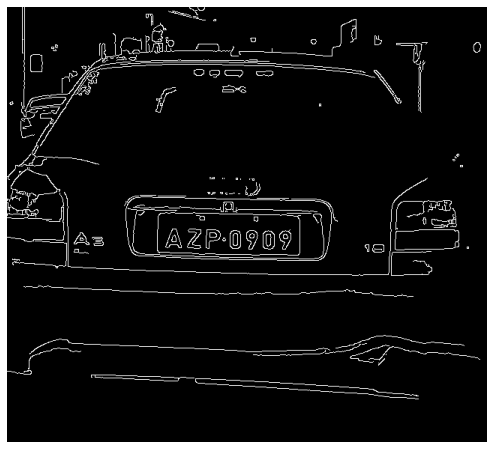

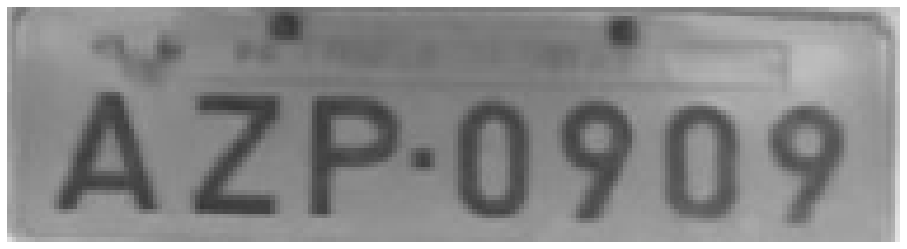

ETSAZP0909


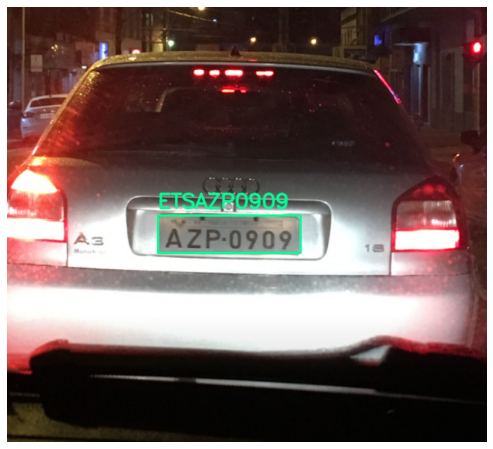

In [ ]:
img, plate = recognize_plate('/content/images/car3.jpg')

In [ ]:
def preprocessing(img):
  increase = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)
  value, otsu = cv2.threshold(increase, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  return otsu

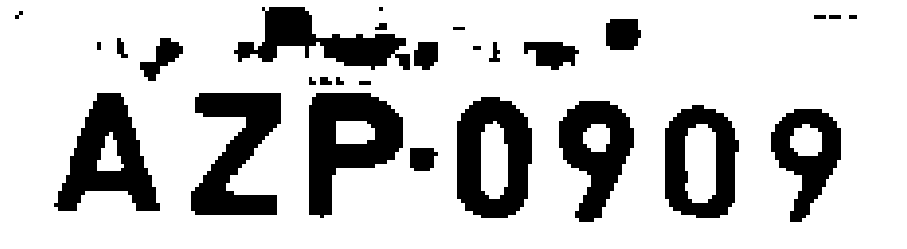

AZP0909


In [ ]:
processed_plate = preprocessing(plate)
show_img(processed_plate)
text = ocr_plate(processed_plate)
print(text)